# Includes 1

In [355]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math

from scipy import spatial
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error

color_list =["#3eb991","#e9a820","#e01563","#edb196","#6ecadc","#1f94ac","#ae9a6a","#ccb8a6","#343a44"]


Global defintions

In [356]:
total_time = 250000;  # in seconds?
delta_T = 100; 
indexed_time = int(total_time / delta_T);  # used to index through time list

swimmer_Radius = 1 * pow(10, -6);  # this is the swimmer size (too small?), so that when they divide their centers will be offset by this

# Diffusion Module

In [357]:
# defining function for diffusion in 3D over time
def single_step(X, Y, theta, delta_T, f, pwInteractionsX, pwInteractionsY):

    # defining variables
    v = 1 * pow(10, -6);   # linear velocity of the swimmers (in m/sec)
    omega = 0;   # angular velocity of the swimmers (in rad/sec)
    D_r = 0.05;   # rotational diffusion coefficient (in sec^-1)
    D_t = 0.1 * pow(10, -12);   # linear diffusion coefficient (in m^2)

    delta_X, delta_Y = 0, 0;   # initializing dx, dy
    delta_theta = 0;   # inditializing dtheta

    # randomly sampling in a uniform distribution from 0 to 1 to get an angle
    W_theta = (math.pi / 2) * np.random.uniform(-1, 1);  

    # randomly sampling noise in Gaussian distrib. with mean 0 and variance 1
    W_X = np.random.normal(0, 1);  
    W_Y = np.random.normal(0, 1);  

    # sums for X and Y components
    sumsX = 0;  
    sumsY = 0;  

    for j in range(0, len(pwInteractionsX), 1):
        if not j == f:
            sumsX = sumsX + pwInteractionsX[f][j];  
            sumsY = sumsY + pwInteractionsY[f][j];  

    if math.isnan(sumsX):
        sumsX = 0;  
    elif sumsX > swimmer_Radius:
        sumsX = swimmer_Radius;  
    elif sumsX < -swimmer_Radius:
        sumsX = -swimmer_Radius;  
    if math.isnan(sumsY):
        sumsY = 0;  
    elif sumsY > swimmer_Radius:
        sumsY = swimmer_Radius;  
    elif sumsY < -swimmer_Radius:
        sumsY = -swimmer_Radius;  

    # solving change in position for each dimension
    delta_X = v * np.cos(theta) * delta_T + np.sqrt(2 * D_t * delta_T) * W_X + sumsX * delta_T
    delta_Y = v * np.sin(theta) * delta_T + np.sqrt(2 * D_t * delta_T) * W_Y + sumsY * delta_T

    # solving change in each angle
    delta_theta = omega * delta_T + np.sqrt(2 * D_r * delta_T) * W_theta;  

    # using a temporary variable to track position and angle
    X += delta_X;  
    Y += delta_Y;  
    theta += delta_theta;  

    temp_postition = [];   # an array to store new values at time t + dt
    temp_postition = np.array([X, Y, theta]);  

    return temp_postition;   # returning coordinates and diffusion coefficient (for comparison later)

# Video graphing module

In [358]:
import os
import cv2
from glob import glob

In [359]:
os.makedirs("../content/graphs/2D", exist_ok=True);   # creates directory if doesn't exist

old_files = glob("../content/graphs/2D/*.png");   # opens directory
for f in old_files: # for all files in this directory with extension .png
    os.remove(f);   # delete files (helpful to remove old files)

In [360]:
def graph_time(x, y, time, status_list): # this module is used to create graphs for video generation, which is called once per time

    fig, ax = plt.subplots();  

    # setting permanent axes
    xlim = 10000 * 1e-6;  
    ylim = 10000 * 1e-6;  

    scale =  100 * pow(swimmer_Radius, 2) / (xlim * ylim) * 75000;  

    ax.set_xlim(-xlim, xlim);  
    ax.set_ylim(-ylim, ylim);  

    plt.scatter(x, y, s = scale, c = status_list);  

    # plt.grid();  

    ax.set_aspect('equal');  

    ax.set_title(f"time: {time} * dt, N = {len(x)}");   # setting title with current time

    plt.rcParams['savefig.dpi'] = 300;  

    plt.xticks(rotation=45, ha='right');  

    # images will be stored to a folder called content/graphs/2D with the <time>.png
    # note that the folder `content` was used for compatbility with Google Colab
    if (time < 10): # using for naming, probably a smarter way to do this
        plt.savefig(f"../content/graphs/2D/0000{time}");  
    elif (time < 100):
        plt.savefig(f"../content/graphs/2D/000{time}");  
    elif (time < 1000):
        plt.savefig(f"../content/graphs/2D/00{time}");  
    elif (time < 10000):
        plt.savefig(f"../content/graphs/2D/0{time}");  
    else:
        plt.savefig(f"../content/graphs/2D/{time}");  

    plt.close();  

# Swimming class

In [361]:
class makeSwimmer: # defines swimmer class
  def __init__(self, x, y, theta, start_time, parent): # one can enter with 0, 0, 0 start or other
    self.start_time = start_time;  
    self.position = np.array([[x, y, theta]]);  
    self.parent = parent;   # the index of the swimmer you diverged from (in the list)
    self.swimming = True;   # this will define if the swimmer is swimming or still, True = swim, False = still
    self.displacement = [0];  
    self.status = True;  
    self.living = True;  
    self.density = 0; 

# Probabilities

In [362]:
# poisson distributed
def check_death(dt, density):
    x = 1;  
    lam = 1e-5 * dt;   

    density_max = 10; 

    P_die = pow(((density + 1) / density_max), 2) * (math.exp(-lam) * pow(lam, x)) / math.factorial(x);  

    bool_temp = False;  
    if P_die > np.random.uniform(0, 1):
        bool_temp = True;  
    return bool_temp;  

In [363]:
# poisson distributed
def check_settling(dt):
    x = 1;   
    lam = 1e-5 * dt;  

    P_set = (math.exp(-lam) * pow(lam, x)) / math.factorial(x);  

    bool_temp = False;  
    if P_set > np.random.uniform(0, 1):
        bool_temp = True;  
    return bool_temp;  

In [364]:
# poisson distributed
def check_doubling(dt, density):
    x = 1;  
    lam = 1e-4 * dt;  

    density_max = 10; 

    P_doub = (1 - (density / density_max)) * (math.exp(-lam) * pow(lam, x)) / math.factorial(x);  

    bool_temp = False;  
    if P_doub > np.random.uniform(0, 1):
        bool_temp = True;  
    return bool_temp;  

# Main

In [365]:
swimmerList = [];  # a list of swimmers
for i in range(0, 1, 1): # initializes a list of 10 swimmers
    swimmerList.append(makeSwimmer(0, 0, 0, 0, 0));  # set starting point at 0, 0

population_size = []; 
start_times = [0];  # will be helpful later and save a ton of comp. power

alive_count_list = []; 
dead_count_list = []; 

for time in range(0, indexed_time, 1):

    population_size.append(len(swimmerList)); 

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% For steric interactions:
    # Hard sphere correction model (page 226 of Simulating ABP Volpe)

    bool_separated = False;  # okay so---I'm encasing this entire code into a boolean to ensure everything is actually separated properly
    while not bool_separated:

      temp_coords_list = np.array([[0,0]]);  # temporary list to store every swimmer position (faster to access than each object)
      status_list = []; 

      count_alive = 0; 
      count_dead = 0; 
      status_index = 0; 

      for i in range(0, len(swimmerList), 1): # inserting each swimmer position into this list, also grabbing living or dead

          if swimmerList[i].living:
              count_alive += 1; 
              if swimmerList[i].swimming:
                  status_index = 'green'; 
              else:
                  status_index = 'yellow'; 
          else:
              count_dead += 1; 
              status_index = 'red'; 

          status_list.append(status_index); 

          time_effective = time - swimmerList[i].start_time;  # to make using the start time easier
          temp_coords_list = np.vstack((temp_coords_list, [swimmerList[i].position[time_effective, 0], swimmerList[i].position[time_effective, 1]])); 
          swimmerList[i].density = 0; 

      alive_count_list.append(count_alive); 
      dead_count_list.append(count_dead); 


      temp_coords_list = np.delete(temp_coords_list, 0, 0);  # remove first element of temp_coords_list, (0,0) at the start

      distances = spatial.distance.cdist(temp_coords_list, temp_coords_list);  # calculates the pairwise distance, in a 2d matrix, of every position with each other

      # note: distances will be a 2d, symmetric matrix with dimensions len(swimmerList) x len(swimmerList)
      # because the matrix is symmetric, we just consider the top triangle half
      indices = np.triu_indices_from(distances);  # this function captures the indices of the top triangle matrix
      temp_x = indices[0];  # I don't know if there is a better way to do this---idk how tuples work
      temp_y = indices[1]; 

      for x in range(0, len(indices[0]), 1):

          # taking the dimenions from the list for the top triangle matrix
          j = temp_x[x]; 
          k = temp_y[x]; 

          if swimmerList[j].living and swimmerList[k].living:
              if distances[j, k] < 0.0005 and not distances[j, k] == 0:
                  swimmerList[j].density += 1; 
          
          if distances[j, k] < 2 * swimmer_Radius and not distances[j, k] == 0: # finding the locations where distances are too small (i.e., swimmers are overlapping)

              time_effective_j = time - swimmerList[j].start_time;  # to make using the start time easier
              time_effective_k = time - swimmerList[k].start_time;  # to make using the start time easier

              magnitude = 2.2 * swimmer_Radius - distances[j, k];  # this is how much we will need to separate them

              local_theta = np.arccos((temp_coords_list[j, 0] - temp_coords_list[k, 0]) / distances[j, k]);  # this finds the angle with which we can separate them to minimize distance

              magnitude_x = magnitude * np.cos(local_theta);  # x distance to separate
              magnitude_y = magnitude * np.sin(local_theta);  # y distance to separate

              # below is to determine which direction to separate in
              if temp_coords_list[j, 0] < temp_coords_list[k, 0]:
                  magnitude_x = -1 * magnitude_x; 
              if temp_coords_list[k, 0] < temp_coords_list[k, 0]:
                  magnitude_y = -1 * magnitude_y; 

              if np.cos(local_theta) > 0:
                  if swimmerList[k].position[time_effective_k, 0] > swimmerList[j].position[time_effective_j, 0]:
                    swimmerList[k].position[time_effective_k, 2] = local_theta; 
                    swimmerList[j].position[time_effective_j, 2] = -local_theta; 
                  else:
                    swimmerList[j].position[time_effective_j, 2] = local_theta; 
                    swimmerList[k].position[time_effective_k, 2] = -local_theta; 
              else:
                  if swimmerList[k].position[time_effective_k, 0] < swimmerList[j].position[time_effective_j, 0]:
                    swimmerList[k].position[time_effective_k, 2] = local_theta; 
                    swimmerList[j].position[time_effective_j, 2] = -local_theta; 
                  else:
                    swimmerList[j].position[time_effective_j, 2] = local_theta; 
                    swimmerList[k].position[time_effective_k, 2] = -local_theta; 

              # note: the indices here are nightmare-ish
              # I am essentially only moving the swimming swimmer, assuming that stalled / stopped swimmers are static
              # this will be helpful for when the swimmers are clustered---i.e., moving them all is not feasible
              if swimmerList[j].swimming and swimmerList[k].swimming:

                  swimmerList[j].position[time_effective_j, 0] = swimmerList[j].position[time_effective_j, 0] + 0.5 * magnitude_x; 
                  swimmerList[j].position[time_effective_j, 1] = swimmerList[j].position[time_effective_j, 1] + 0.5 * magnitude_y; 

                  swimmerList[k].position[time_effective_k, 0] = swimmerList[k].position[time_effective_k, 0] - 0.5 * magnitude_x; 
                  swimmerList[k].position[time_effective_k, 1] = swimmerList[k].position[time_effective_k, 1] - 0.5 * magnitude_y; 

              elif swimmerList[j].swimming:

                  swimmerList[j].position[time_effective_j, 0] = swimmerList[j].position[time_effective_j, 0] + magnitude_x; 
                  swimmerList[j].position[time_effective_j, 1] = swimmerList[j].position[time_effective_j, 1] + magnitude_y; 

              elif swimmerList[k].swimming:

                  swimmerList[k].position[time_effective_k, 0] = swimmerList[k].position[time_effective_k, 0] - magnitude_x; 
                  swimmerList[k].position[time_effective_k, 1] = swimmerList[k].position[time_effective_k, 1] - magnitude_y; 

              else: # this is just an error fail safe

                  swimmerList[j].position[time_effective_j, 0] = swimmerList[j].position[time_effective_j, 0] + 0.5 * magnitude_x; 
                  swimmerList[j].position[time_effective_j, 1] = swimmerList[j].position[time_effective_j, 1] + 0.5 * magnitude_y; 

                  swimmerList[k].position[time_effective_k, 0] = swimmerList[k].position[time_effective_k, 0] - 0.5 * magnitude_x; 
                  swimmerList[k].position[time_effective_k, 1] = swimmerList[k].position[time_effective_k, 1] - 0.5 * magnitude_y; 
          else:
              bool_separated = True;  # this algorithm will iterate through multiple times until the swimmers are all separated
              # the reason it might need to loop through more than once is if a swimmer gets re-positioned into another swimmer

      bool_separated = True; 
    


    dt_per_graph = 10; 
    if time % dt_per_graph == 0: # defines how often we decide to graph---right now, we graph every 10 dt
        graph_time(temp_coords_list[:,0], temp_coords_list[:,1], time, status_list);  # calls our graphing function

    if time == indexed_time:
        break; 

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% For hydrodynamics:

    n = len(swimmerList); 
    pwInteractionsX = np.zeros((n, n)); 
    pwInteractionsY = np.zeros((n, n)); 

    c = 3.18*pow(10,-17); 
    alpha = -1000 * pow(10, -17); 
    for i in range(len(swimmerList)):
      if swimmerList[i].living:
          for j in range(len(swimmerList)):
              # effect of j on i
              if not j == i:
                if swimmerList[j].living:

                  time_effective_j = time - swimmerList[j].start_time; 

                  r = distances[i, j]; 
                  local_theta = swimmerList[j].position[time_effective_j, 2]; 
                  local_x_comp = r * np.cos(local_theta); 
                  local_y_comp = r * np.sin(local_theta); 

                  if swimmerList[i].swimming == True and swimmerList[j].swimming == True:

                    temp_x = c * ((1 / pow(r, 3)) + (3 * pow(local_x_comp, 2)) / pow(r,5)) * r; 
                    
                    pwInteractionsX[i][j] = c * ((1 / pow(r, 3)) + (3 * pow(local_x_comp, 2)) / pow(r,5)) * r; 
                    pwInteractionsY[i][j] = c * ((1 / pow(r, 3)) + (3 * pow(local_y_comp, 2)) / pow(r,5)) * r; 
              
                  elif swimmerList[i].swimming == True and swimmerList[j].swimming == False:

                    pwInteractionsX[i][j] = -alpha * (local_x_comp / pow(r, 3)); 
                    pwInteractionsY[i][j] = -alpha * (local_y_comp / pow(r, 3)); 

    for i in range(0, len(swimmerList), 1):

      time_effective = time - swimmerList[i].start_time;  # to make using the start time easier
      arr = swimmerList[i].position[time_effective];  # to store the previous position

      a = check_death(delta_T, swimmerList[i].density); 
      b = check_settling(delta_T); 
      c = check_doubling(delta_T, swimmerList[i].density); 

      temp_coords = single_step(arr[0], arr[1], arr[2], delta_T, i, pwInteractionsX, pwInteractionsY);  # stores its current coordinates

      if swimmerList[i].living: # added to ensure dead swimmers do not divide lol
        if a == False:
          if swimmerList[i].swimming:
            if b == True: # settling
              swimmerList[i].swimming = False; 
              swimmerList[i].position = np.vstack((swimmerList[i].position, arr));  # adds new dt coordinates, which are temporarily stored in temp_coords
            else:
              swimmerList[i].position = np.vstack((swimmerList[i].position, temp_coords));  # adds new dt coordinates, which are temporarily stored in temp_coords
          elif c == True:
            divide_Angle = np.random.normal(0, 2 * math.pi);  # picking a random angle to divide along
            x_after_divide = arr[0] + np.cos(divide_Angle) * 2.1 * swimmer_Radius;  # causes next swimmer to start around body length away
            y_after_divide = arr[1] + np.sin(divide_Angle) * 2.1 * swimmer_Radius; 
            swimmerList.append(makeSwimmer(x_after_divide, y_after_divide, swimmerList[i].position[time_effective, 2], time + 1, i));  # set starting point current swimmer position plus an offset along a random angle with parallel orientation
            start_times.append(time + 1); 
            swimmerList[i].position = np.vstack((swimmerList[i].position, arr));  # adds same coordinates to current swimmer (staying still after dividing)
          else:
            swimmerList[i].position = np.vstack((swimmerList[i].position, arr));  # adds same coordinates to current swimmer (staying still)
        else:
          #can you remove these guys or give them a value that will well you filter them(not immediately, but after the time step). These are the dead ones.
          swimmerList[i].living = False; 
          swimmerList[i].position = np.vstack((swimmerList[i].position, arr));  # adds new dt coordinates, which are temporarily stored in temp_coords
      else:
        swimmerList[i].position = np.vstack((swimmerList[i].position, arr));  # adds new dt coordinates, which are temporarily stored in temp_coords


      displacement = np.sqrt(pow(swimmerList[i].position[time_effective + 1, 0], 2) + pow(swimmerList[i].position[time_effective + 1, 1], 2)); 
      swimmerList[i].displacement.append(displacement); 

final_x = [];  # storing the final positions, for looking at the shape of the colony at the end
final_y = []; 
for i in np.arange(0, len(swimmerList), 1):
    final_x.append(swimmerList[i].position[-1,0]); 
    final_y.append(swimmerList[i].position[-1,1]); 

# Graphing

124.21377720988258 and 51.34546816062145


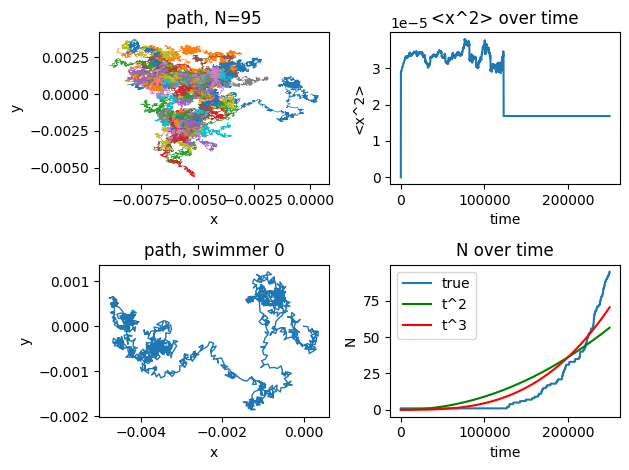

In [ ]:
# 2d graphing definitions
plt.subplot(2, 2, 1);   # putting plots on the same image, this at row 1, col 1, index 1
for i in range(0, len(swimmerList), 1):
    plt.plot(swimmerList[i].position[:,0], swimmerList[i].position[:,1], linewidth=0.5);  
    # here, : takes all values at position 0 (x) or 1 (y) for each swimmer in the list
    # plot then graphs all of those x and y independently

plt.xlabel('x')
plt.ylabel('y')
plt.title("path, N=" + str(len(swimmerList)))
plt.tight_layout()
# plt.gca().set_aspect(0.75)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

mean_squared_displacement = [0];  
for time in range(1, indexed_time, 1):
    temp = 0;  
    count = 0;  
    for i in range(0, len(swimmerList), 1):
          if time < len(swimmerList[i].position):
                temp += pow(swimmerList[i].displacement[time], 2);  
                count += 1;  
    mean_squared_displacement.append(temp / count);  

plt.subplot(2, 2, 2);   # putting plots on the same image, this at row 1, col 1, index 1
plt.plot(np.arange(0, total_time, delta_T), mean_squared_displacement);  
plt.xlabel('time')
plt.ylabel('<x^2>')
plt.title("<x^2> over time")
plt.tight_layout()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

plt.subplot(2, 2, 3);   # putting plots on the same image, this at row 1, col 1, index 1
plt.plot(swimmerList[0].position[:,0], swimmerList[0].position[:,1], linewidth=1);  

plt.xlabel('x')
plt.ylabel('y')
plt.title("path, swimmer 0")
plt.tight_layout()
# plt.gca().set_aspect(0.75)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

plt.subplot(2, 2, 4);   # putting plots on the same image, this at row 1, col 1, index 1

local_x = np.arange(0, total_time, delta_T) # setting range of x values to be time in this variable

def time_squared(x, a): # a function used to see if the data fits well to t^2, with coefficient `a`
    return a * pow(x, 2);  

def time_cubed(x, a): # a function used to see if the data fits well to t^3, with coefficient `a`
    return a * pow(x, 3);  

def time_exp(x, a, b): # a function used to see if the data fits well to t^4, with coefficient `a`
    return a * np.exp(b * x);  

# below is where the paramters for the fits are stored---in this case `a`
param_squared, param_cov_squared = curve_fit(time_squared, local_x, population_size);  
param_cubed, param_cov_cubed = curve_fit(time_cubed, local_x, population_size);  

# here is where new y values are calculated based on our fits, and parameter `a`
fit_squared = (param_squared[0] * pow(local_x, 2));  
fit_cubed = (param_cubed[0] * pow(local_x, 3));  

# here we plot the true y values, and the predicted y values for each fit from above
plt.plot(local_x, population_size, label = 'true');  
plt.plot(local_x, fit_squared, color = 'green', label = 't^2');  
plt.plot(local_x, fit_cubed, color = 'red', label = 't^3');  

# here we compute the mean squared error using the sklearn library for each of the fits vs. the true values
squared_error = mean_squared_error(population_size, fit_squared);  
cubed_error = mean_squared_error(population_size, fit_cubed);  

print(f"{squared_error} and {cubed_error}");   # printing the errors

plt.xlabel('time')
plt.ylabel('N')
plt.title("N over time")
plt.tight_layout()
plt.legend()
# plt.gca().set_aspect('equal')

Final position

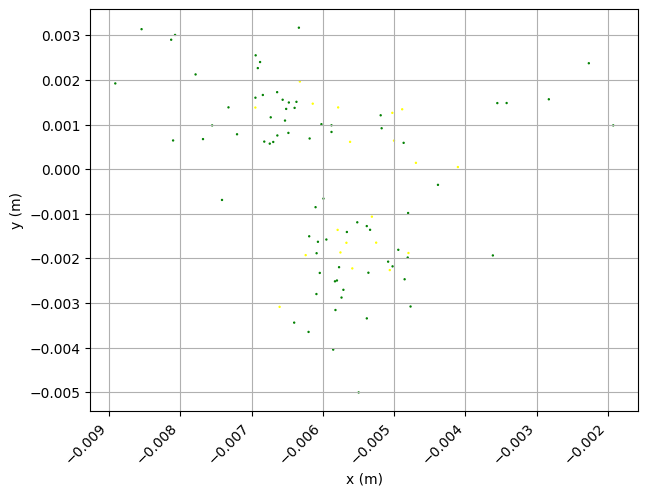

In [ ]:
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.tight_layout()

# xlim = 1000 * 1e-6;  
# ylim = 1000 * 1e-6;  

# scale = 10000 * pow(swimmer_Radius, 2) / (xlim * ylim) * 75000;  

# plt.xlim(-xlim, xlim);  
# plt.ylim(-ylim, ylim);  

scale = 0.5

plt.xticks(rotation=45, ha='right');  

plt.scatter(final_x, final_y, s = scale, c = status_list);  

plt.grid(); 

plt.savefig(f"../content/graphs/2D/final, N={len(swimmerList)}", dpi=300); 

# plt.gca().set_aspect('equal');  

plt.show();  

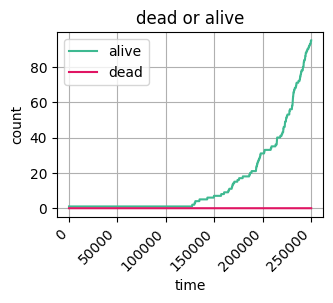

124.21377720988258 and 51.34546816062145


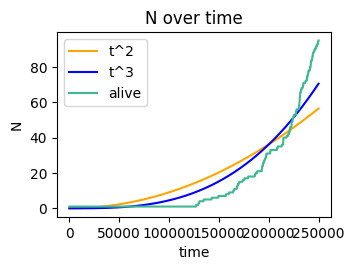

In [ ]:
plt.subplot(2, 2, 1);   # putting plots on the same image, this at row 1, col 1, index 1

plt.xlabel('time');  
plt.ylabel('count');  
plt.title("dead or alive");  
plt.tight_layout()

local_x = np.arange(0, total_time, delta_T) # setting range of x values to be time in this variable

plt.xticks(rotation=45, ha='right');  

plt.plot(local_x, alive_count_list, label = "alive", color = color_list[0]);  
plt.plot(local_x, dead_count_list, label = "dead", color = color_list[2]);  

plt.grid();  

plt.legend();  

plt.show();  

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

plt.subplot(2, 2, 2);   # putting plots on the same image, this at row 1, col 1, index 1

local_x = np.arange(0, total_time, delta_T) # setting range of x values to be time in this variable

def time_squared(x, a): # a function used to see if the data fits well to t^2, with coefficient `a`
    return a * pow(x, 2);  

def time_cubed(x, a): # a function used to see if the data fits well to t^3, with coefficient `a`
    return a * pow(x, 3);  

def time_exp(x, a, b): # a function used to see if the data fits well to exp, with coefficient `a` and `b`
    return a * np.exp(b * x);  

# below is where the paramters for the fits are stored---in this case `a`
param_squared, param_cov_squared = curve_fit(time_squared, local_x, alive_count_list);  
param_cubed, param_cov_cubed = curve_fit(time_cubed, local_x, alive_count_list);  

# here is where new y values are calculated based on our fits, and parameter `a`
fit_squared = (param_squared[0] * pow(local_x, 2));  
fit_cubed = (param_cubed[0] * pow(local_x, 3));  

# here we plot the true y values, and the predicted y values for each fit from above
# plt.plot(local_x, population_size, label = 'total');  
plt.plot(local_x, fit_squared, color = 'orange', label = 't^2');  
plt.plot(local_x, fit_cubed, color = 'blue', label = 't^3');  
plt.plot(local_x, alive_count_list, label = 'alive', color = color_list[0]);  

# here we compute the mean squared error using the sklearn library for each of the fits vs. the true values
squared_error = mean_squared_error(alive_count_list, fit_squared);  
cubed_error = mean_squared_error(alive_count_list, fit_cubed);  

plt.xlabel('time');  
plt.ylabel('N');  
plt.title("N over time");  
plt.tight_layout();  
plt.legend();  

print(f"{squared_error} and {cubed_error}");   # printing the errors

# Make video

In [ ]:
image_folder = '../content/graphs/2D';   # the folder containing the images
video_name = '../content/graphs/video.mp4';   # the name of the video generated

fourcc = cv2.VideoWriter_fourcc(*'mp4v');   # helps openCV understand how to format the video

images = [img for img in os.listdir(image_folder) if img.endswith(".png")];   # puts all of the images into this list
frame = cv2.imread(os.path.join(image_folder, images[0]));   # finds the frame of the images
height, width, layers = frame.shape;   # creates dimensions based on the read frames

fps = 10;   # sets frames per second of video (I think;   it may also set some similarly scaled value)
video = cv2.VideoWriter(video_name, fourcc, fps, (width,height));   # creates video with specifications set by frame and other

images.sort();   # needed because, for some weird reason, it will read in the images in a strange order

for image in images: # take all of the images and combine them together, and save to image_folder
    video.write(cv2.imread(os.path.join(image_folder, image)));  

cv2.destroyAllWindows();  
video.release();  